# 5교시 1.설명 가능한 딥러닝 모델 만들기
- 은닉층 안에서 어떤 일이 일어나는지 알 수 없다.
- 하지만 가중치가 어떻게 변하는지는 알 수 있다.
- 입력값을 바꾸어가면서 어떤 입력값이 어떤 역할을 하는지는 추적할 수 있다.
- 이 분야가 XAI

- 큰 종류 -> CAM방식, Occlusion 방식
- **CAM**: conv 진행. 가장 마지막에서 가장 마지막(알츠하이머이다 예측한 부분)에서 결과값을 이용해서, 바로 이전에 가중치 경사하강법으로 역추적해서 weight값이 어떻게 변했는지 확인

- **Occlusion**: 이미지 일부를 각각 다른 부분으로 가려서 모델이 예측이 어떻게 변하는지 관찰하는 방법 (예-강아지 왼쪽 상단 / 상단 중앙 ) - 어떤 부분을 뺐을 때 정확도가 가장 낮은지 보면, 어떤 부분이 예측에 가장 중요했는지 알 수 있다.
  - patch size(masking part)를 작게 설정할수록 모델이 결과 예측에 더 중요하게 작용하는 부분을 알려줌

## 1. 설명 가능한 딥러닝의 실행

In [1]:
!pip install tf-explain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00


Cloning into 'data'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 36 (delta 9), reused 26 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 483.12 KiB | 2.30 MiB/s, done.
Resolving deltas: 100% (9/9), done.


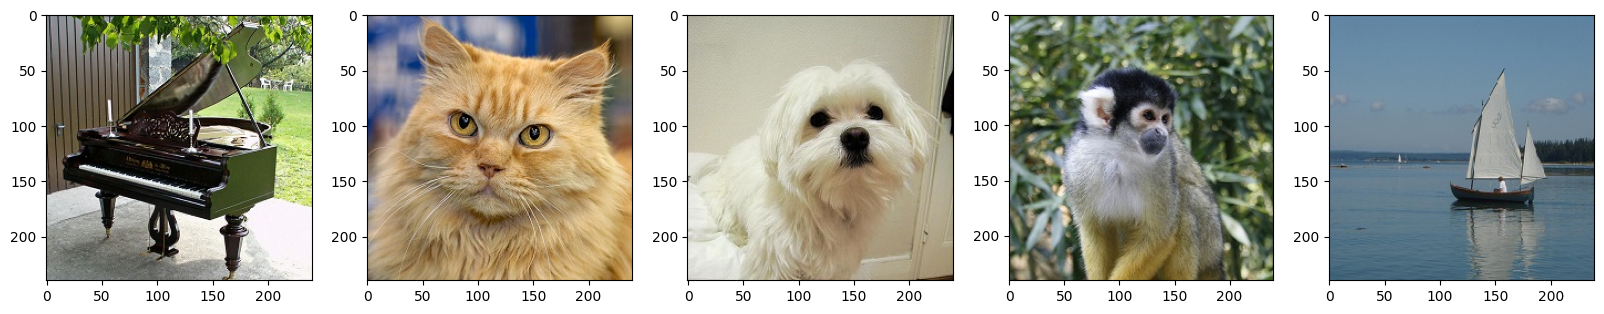

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16

# XAI 알고리즘을 불러오는 부분입니다.
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 깃허브에 준비된 데이터를 가져옵니다.
!git clone https://github.com/taehojo/data.git

# 원본 이미지가 들어갈 리스트 만들기
images_originals = []

# 원본 이미지가 저장된 폴더에서 하나씩 불러와 리스트에 넣기
for img_path in glob.glob('./data/img/*_0.jpg'):
    images_originals.append(mpimg.imread(img_path))

# 코랩에서 보여 줄 이미지의 크기
plt.figure(figsize=(20,20))

# 원본 이미지를 코랩에서 보이게 하기
for i, image_o in enumerate(images_originals):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_o)

-----
Grad-CAM 방식

<img src="https://github.com/taehojo/fastcampus_ai/blob/master/data/img/05-01.png?raw=1" width="400"/>

In [7]:
model = VGG16(weights="imagenet", include_top=False) #맨 마지막 레이어 불러와야함.
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_122']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_122']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_122']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_122']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
 

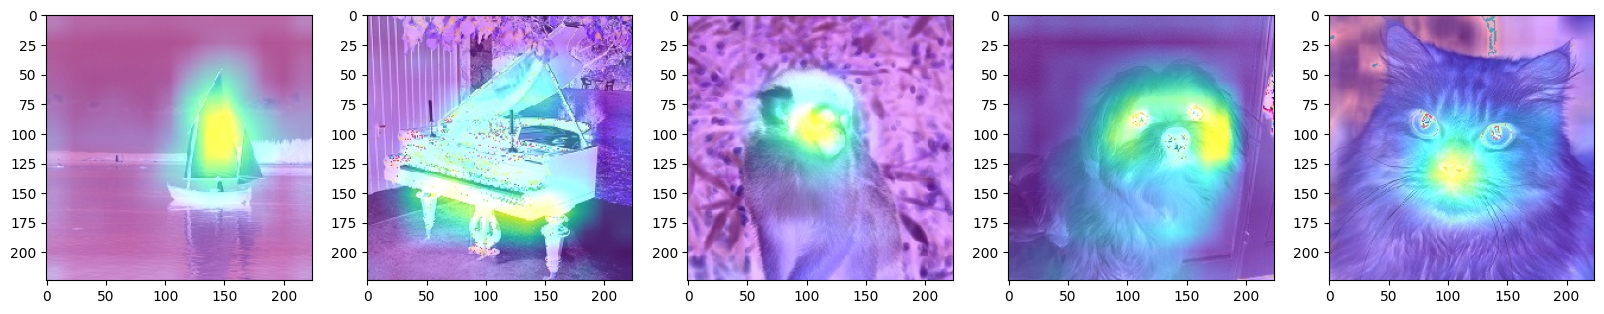

In [12]:
# 사전에 학습된 딥러닝 모델 불러오기
model = VGG16(weights="imagenet", include_top=True) #맨 마지막 레이어 불러와야함.

# 원본 이미지 이름과 Imagenet에서의 해당 이미지 인덱스
input_list = ["maltese", "persian_cat", "squirrel_monkey", "grand_piano", "yawl"]
imagenet_index = ["153", "283", "382", "579", "914"]

# 그레이디언트 CAM 알고리즘 선택
explainer = GradCAM()
target_layer = "block5_conv3"

# 그레이디언트 CAM 알고리즘이 적용된 이미지가 들어갈 빈 리스트 만들기
images_cams = []

# 그레이디언트 CAM 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224)) # 이미지를 불러오고 내부에서 처리될 이미지의 크기를 설정합니다.
    img = img_to_array(img) # 이미지를 넘파이 배열로 바꾸어 줍니다.
    data = ([img], None)
    grid = explainer.explain(data, model, int(i),layer_name=target_layer)   # 그레이디언트 CAM이 실행되는 부분입니다.
    explainer.save(grid, ".", './data/img/{}_cam.jpg'.format(l))  # 실행 후 저장되는 이름입니다.

# 그레이디언트 CAM 알고리즘이 적용된 이미지를 불러오는 부분의 시작입니다.
plt.figure(figsize=(20,20))

for img_path in glob.glob('./data/img/*_cam.jpg'):
    images_cams.append(mpimg.imread(img_path))

for i, image_c in enumerate(images_cams):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image_c)

----
Occlusion 방식

<img src="https://github.com/taehojo/fastcampus_ai/blob/master/data/img/05-02.png?raw=1" width="400"/>

2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step


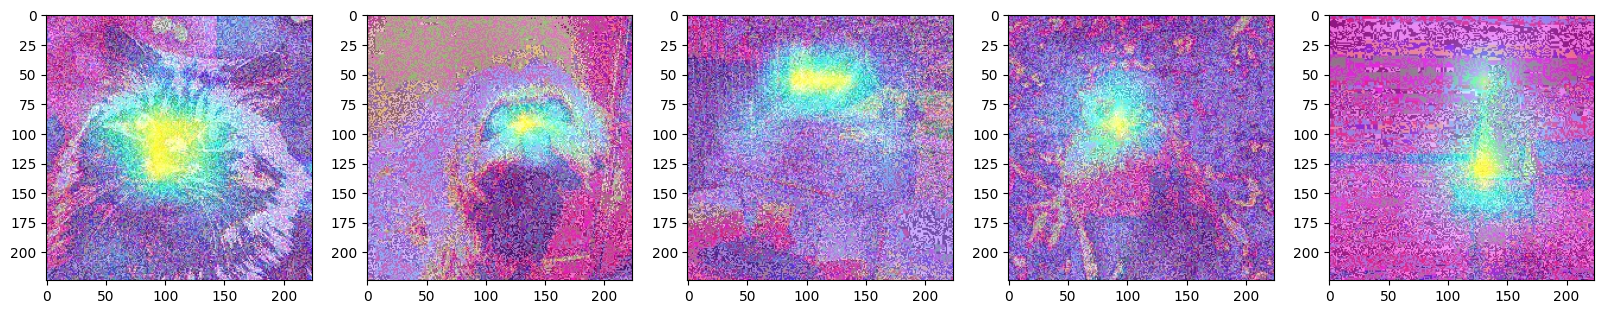

In [13]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np

# 오클루전 알고리즘을 불러와 실행합니다.
explainer = OcclusionSensitivity()

# 알고리즘이 적용된 이미지가 들어갈 빈 리스트 만들기
images_occ1s = []

# 패치 사이즈를 정합니다. mask의 크기
patch_size = 40

# 오클루전 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    img = preprocess_input(img)  # 전처리
    img = np.expand_dims(img, axis=0)  # (1, 224, 224, 3)

    data = (img, None)
    grid = explainer.explain(data, model, int(i), patch_size) # 패치 사이즈의 설정이 추가됩니다.
    explainer.save(grid, ".", './data/img/{}_occ1.jpg'.format(l))

# 오클루전 알고리즘이 적용된 이미지를 불러오는 부분의 시작입니다.
plt.figure(figsize=(20,20))

for img_path in glob.glob('./data/img/*_occ1.jpg'):
    images_occ1s.append(mpimg.imread(img_path))

for i, image in enumerate(images_occ1s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


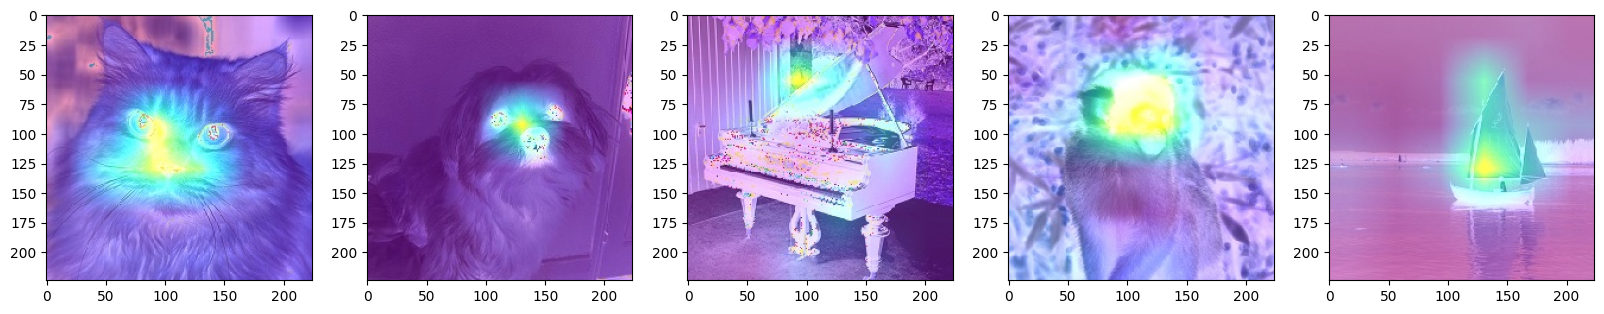

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np

# 오클루전 알고리즘을 불러와 실행합니다.
explainer = OcclusionSensitivity()

# 알고리즘이 적용된 이미지가 들어갈 빈 리스트 만들기
images_occ1s = []

# 패치 사이즈를 정합니다. mask의 크기
patch_size = 40

# 오클루전 알고리즘 실행
for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size) # 패치 사이즈의 설정이 추가됩니다.
    explainer.save(grid, ".", './data/img/{}_occ1.jpg'.format(l))

# 오클루전 알고리즘이 적용된 이미지를 불러오는 부분의 시작입니다.
plt.figure(figsize=(20,20))

for img_path in glob.glob('./data/img/*_occ1.jpg'):
    images_occ1s.append(mpimg.imread(img_path))

for i, image in enumerate(images_occ1s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)

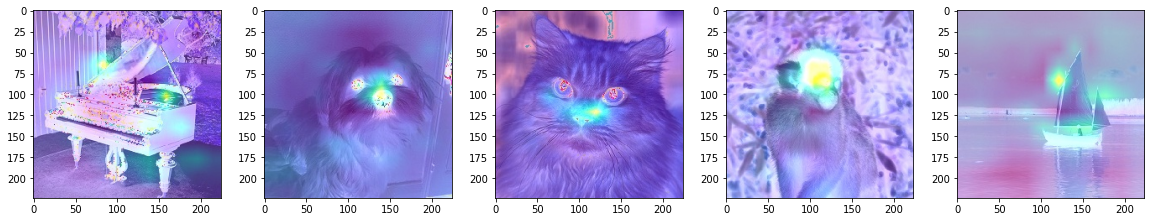

In [ ]:
patch_size = 20

images_occ2s = []

for l, i in zip(input_list, imagenet_index):
    img = load_img('./data/img/{}_0.jpg'.format(l), target_size=(224, 224))
    img = img_to_array(img)
    data = ([img], None)
    grid = explainer.explain(data, model, int(i), patch_size)
    explainer.save(grid, ".", './data/img/{}_occ2.jpg'.format(l))

for img_path in glob.glob('./data/img/*_occ2.jpg'):
    images_occ2s.append(mpimg.imread(img_path))

plt.figure(figsize=(20,20))
for i, image in enumerate(images_occ2s):
    plt.subplot(5, 5, i + 1)
    plt.imshow(image)


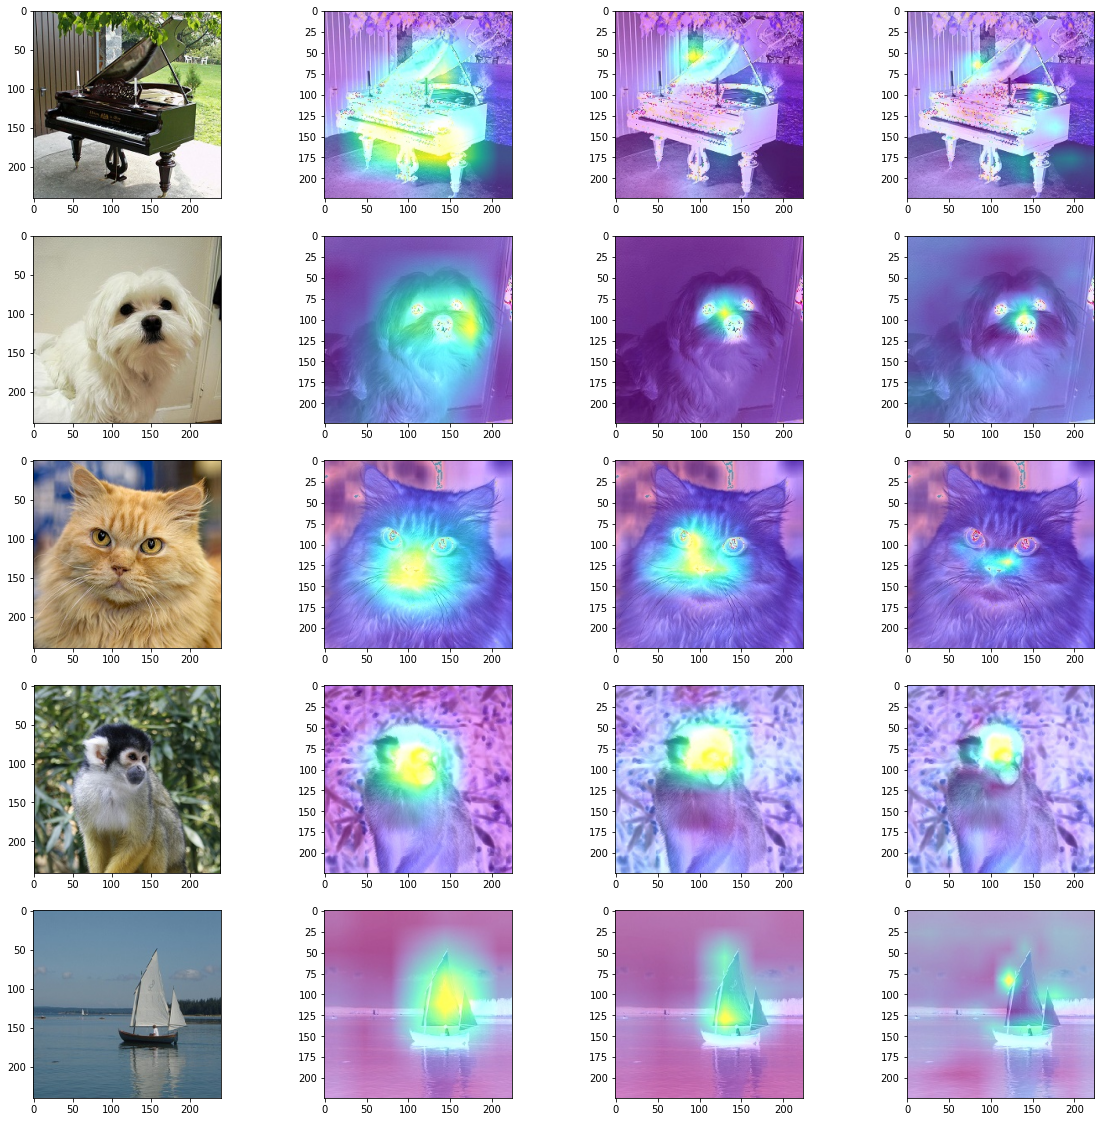

In [ ]:
# 전체 이미지 한 눈에 보기.

plt.figure(figsize=(20,20))

images = []
for img_path in glob.glob('./data/img/*.jpg'):
    images.append(mpimg.imread(img_path))

for i, image in enumerate(images):
    plt.subplot(5, 4, i + 1)
    plt.imshow(image)